# Segmentation of Indian Traffic

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# LOADING THE REQUIRED LIBRARIES
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import os
import re
import shutil

## 1. Get all the file name and corresponding json files

In [2]:
'''THIS FUNCTION LIST THE PATH FOR ALL THE IMAGES AND JSON FILES'''

def return_file_names_df(root_dir):
    
    images = [] # LIST FOR STORING IMAGES PATH
    for i in os.listdir( root_dir+ "images"): 
        for j in os.listdir(root_dir + "images/" + i) :
            images.append(root_dir + "images/" + i+"/"+j)
        
    json = [] # LIST FOR STORING JSON FILES PATH
    for i in os.listdir(root_dir + "mask"):
        for j in os.listdir(root_dir + "mask/" + i):
            json.append( root_dir + "mask/" + i+ "/" + j)
    
    # FORMING THE DATAFRAME WITH IMAGES AND JSON FILE PATH
    data_df = pd.DataFrame()
    data_df["images"] = images
    data_df["json"] = json
    
    return data_df # RETURNING THE DATAFRAME

In [4]:
root_dir = "data/" #STORING THE ROOT DIRECTORY IN A VARIABLE
data_df = return_file_names_df(root_dir) # GETTING THE DATAFRAME WITH PATHS
data_df.head()

,images,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


## 2. Structure of sample Json file

In [ ]:
'''THIS FUNCTION RETURNS THE UNIQUE LABELS'''

def return_unique_labels(data_df):
    
    unique_labels = [] # LIST FOR STORING UNIQUE LABELS
    for i in data_df.json: # FOR EACH PATH IN THE DATAFEAME
        f= open(i) # OPEN THE FILE
        j_data=json.load(f) # LOADING FILE AS JSON FILE
        
        label=  [] # STORING LABLES WITHIN A FILE 
        for j in j_data["objects"]: # FOR EACH OBJECT IN THE FILE 
            label.append(j["label"]) # APPEND THE LABEL 
            
        unique_labels.extend(label) # EXTEND THE LIST FOR LABEL TO UNIQUE LABELS
        
    return list(set(unique_labels)) # RETURN UNIQUE LABELS

In [ ]:
'''GETTING THE UNIQUE LABELS'''

unique_labels = return_unique_labels(data_df) # STORING UNIQUE LABELS IN A VARIABLE
unique_labels 

['person',
 'sky',
 'caravan',
 'bus',
 'wall',
 'ground',
 'trailer',
 'out of roi',
 'polegroup',
 'rectification border',
 'motorcycle',
 'curb',
 'fence',
 'vegetation',
 'autorickshaw',
 'ego vehicle',
 'train',
 'sidewalk',
 'traffic light',
 'building',
 'pole',
 'tunnel',
 'traffic sign',
 'drivable fallback',
 'rider',
 'truck',
 'car',
 'bridge',
 'obs-str-bar-fallback',
 'parking',
 'billboard',
 'unlabeled',
 'bicycle',
 'non-drivable fallback',
 'guard rail',
 'vehicle fallback',
 'rail track',
 'animal',
 'road',
 'fallback background']

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

## 3. Extracting the polygons from the json files

In [ ]:
'''THIS FUNCTION EXTRACTS THE IMAGE HEIGHT, IMAGE WIDTH, LABELS AND  VERTEX LIST '''

def get_poly(file):
    
    f = open(file) # OPENING THE FILE 
    j=json.load(f) # LOADING AS JSON FILE
     
    h = j['imgHeight'] # EXTRACTING THE IMAGE HEIGHT 
    w = j["imgWidth"] # EXTRACTING THE IMAGE WIDTH
    label = [] # STIORING THE LABEL
    vertexlist = [] # STORING THE VERTEX FOR THE LABESL IN A LIST
    
    for i in j["objects"]: # FOR EACH OBJECT IN THE FILE
        label.append(i["label"]) # APPEND THE LABEL
        vertexlist.append([tuple(k) for k in i["polygon"]]) # APPEND THE LIST OF VERTICES FOR THE LABEL 
        
    return w, h, label, vertexlist # RETURN WIDTH, HEIGHT, LABELS, VERTEXLIST

## 4. Creating Image segmentations by drawing set of polygons

In [ ]:
'''THIS FUNCTION TAKES INPUT AS DATAFRAME AND FORMS THE MASK AND STORES IT AS .PNG FILE.
IT RETURNS THE DATAFRAME WITH PATH OF INPUT AND MASK FILE'''

def compute_masks(data_df):
    
    output_path  = []  # LIST STORING THE PATH OF MASK 
    
    for index,i in tqdm(data_df.iterrows(),position=0): # FOR EACH ROW IN INPUT DATAFRAME
        
        # COMPUTE THE WIDTH,HEIGHT, LABEL AND VERTEX LIST OF ALL THE OBJECTS IN THE IMAGE
        w,h,label,vertexlist = get_poly(i.json) 
        
        # FORMING A NEW IMAGE WITH WIDTH w AND HEIGHT h
        img = Image.new("RGB",(w,h))
    
        img1 = ImageDraw.Draw(img)
        # FOR EACH LABEL IN LIST OF LABELS
        for j in range(len(label)):
            lbl = label[j] # STORING THE CURRENT LABEL
              
            if len(vertexlist[j])>=2:
                img1.polygon(vertexlist[j],fill  = label_clr[lbl]) #FILL THE COLOR IN THE GIVEN VERTEX OF THE LABELS
        
        # CONVERTING NUMPY ARRAY TO IMAGE
        im =  Image.fromarray(np.array(img)[:,:,0])
       
        # PATH FOR MASK
        path = re.sub("mask","output",i.json) 
        path = re.sub(".json",".png",path)
        # SAVING THE MASK IMAGE
        im.save(path)
        
        # APPENING THE PATH TO  "output_path" LIST
        output_path.append(path)
        
    # ADDING A NEW COLUMN TO INPUT DATAFRAME
    data_df["mask"]=output_path
    
    return data_df # RETURNING THE MODIFIED DATAFRAME

In [ ]:
'''FORMING THE MASK AND SAVING THE PATH IN DATAFRAME'''

data_df = compute_masks(data_df)

4008it [05:22, 12.43it/s]


In [ ]:
data_df.head()

,images,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
data_df.to_csv("df.csv") # SAVING THE DATAFRAME TO CSV

# Loading the CSV File of Paths

In [7]:
'''LOADING THE PATH FILE'''

data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ass-26/df.csv",index_col = [0])
data_df.head()

,images,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [8]:
'''THIS IS MODIFICATION DONE FOR COLAB NOTEBOOKS'''

data_df["images"]= "/content/drive/MyDrive/Colab Notebooks/ass-26/" + data_df["images"].values
data_df["json"] = "/content/drive/MyDrive/Colab Notebooks/ass-26/" + data_df["json"].values
data_df["mask"] = "/content/drive/MyDrive/Colab Notebooks/ass-26/" + pd.DataFrame(data_df["mask"].values).values

#  Applying Unet to segment the images

###  Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [110]:
# LOADING THE LIBRARIES

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import albumentations as A
import re

In [10]:
tf.__version__

'2.5.0'

## Splitting the DataFrame

In [11]:
'''SPLITTING THE DATA IN 80:20 FORMAT'''

df_train , df_test = train_test_split(data_df,test_size=0.2, random_state=30)

In [12]:
df_train.shape

(3206, 3)

In [13]:
df_test.shape

(802, 3)

# Installing Libraries

In [14]:
'''INTALLING THE LIBRARIES REQUIRED FOR SEGMENTATION MODELS'''
!pip install keras==2.3.1
!pip install -U segmentation-models

     |████████████████████████████████| 377 kB 8.1 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


# Code

In [15]:
'''LOADING THE REQUIRED LIBRARIES'''

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')
from matplotlib.image import imsave
from segmentation_models.metrics import iou_score
import imgaug.augmenters as iaa
from albumentations.augmentations.transforms import PadIfNeeded 
from google.colab.patches import cv2_imshow

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [67]:
'''LODING THE UNET MODEL'''

model = Unet('resnet34', encoder_weights='imagenet', classes=21 , activation='softmax',input_shape=(1088,1920,3),encoder_freeze=True)

85524480/85521592 [==============================] - 1s 0us/step


In [68]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 1088, 1920,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 1088, 1920, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 1094, 1926, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 544, 960, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [69]:
'''THIS CELL COMPUTES THE NAMES OF UNIQUE 21 CLASSED OUT OF TOTAL 40 CLASSES'''
# HERE ARE SELECTING THE FIRST CLASS OUT OF ALL THOSE CLASSES WHICH HAS THE SAME COLOR CODING

unique_classes = [] # STORING THE UNIQUE CLASSES IN A LIST 
for i in label_clr.keys(): # FOR EACH CLASS IN THE DICTIONARY LABEL_CLR 
    
    # IF THE LENGTH OF "unique_classes" IS GREATER THAN 1 
    if len(unique_classes)>1:
        # THEN COMPARE THE LAST PRESENT CLASS WITH THE PRESENT CLASS
        # IF THE COLOR OF BOTH IS SAME
        if label_clr[i]==label_clr[unique_classes[-1]]:
            # THEN CONTINUE
            continue
        else:
        # OTHERWISE APPEND THE CLASS TO "unique_classes"
            unique_classes.append(i)
    else:
        # IF THE LENGTH OF LIST "unique_classes" IS ZERO
        unique_classes.append(i)

In [70]:
'''THIS CLASSES FORM THE DATASET'''

class dataset():
    label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
    
    def __init__(self,df,classes,augmentation):
        self.image = df.images.values #STORING THE PATH OF THE IMAGES
        self.mask = df["mask"].values # STORIN THE PATH OF MASKS
        self.classes = [self.label_clr.get(i) for i in classes] # STORING THE CLASS COLOR
        self.aug = augmentation # INITIALIZING THE AUGMENTATIONS
    
    # THIS METHOD READS AND APPLY IMAGE AUGMENTATION TO THE IMAGE AND MASK
    def __getitem__(self,i): 
        # READING THE IMAGE 
        image=cv2.imread(self.image[i],cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # READING THE MASK
        mask  = cv2.imread(self.mask[i],cv2.IMREAD_UNCHANGED)
        # CONVERING 3 CHANNELED IMAGE TO 21 CHANNELS WHERE EACH CHANNEL REPRESENTS THE EACH CLASS
        masks = [(mask==v) for v in self.classes]
        # STACKING THE IMAGE
        mask = np.stack(masks,axis=-1).astype('float32')
        
        # APPLYING THE IMAGE AUGMENTATION TO IMAGES AND MASK 
        image_aug = self.aug(image=image,mask=mask)
        image = image_aug["image"]
        mask= image_aug["mask"]
        
        # RETURNING THE IMAGE AND MASK
        return image, mask
        
    # THIS METHOD RETURNS THE LENGTH OF IMAGE
    def __len__(self):
        return len(self.image)

'''THIS FUNCTION APPLIES AUGMENTATION ON TRAIN DATA'''
def train_aug():
    transform = A.Compose([
                A.PadIfNeeded(min_height=1088, min_width=1920, always_apply=True, border_mode=0),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
                A.RandomBrightnessContrast(p=0.2)]
                
    )
    return transform

'''THIS FUNCNTION APPLIES AUGMENTATION ON TEST DATA'''
def test_aug():
    transform = A.Compose([A.PadIfNeeded(min_height=1088, min_width=1920, always_apply=True, border_mode=0)
        
    ])
    return transform

In [71]:
'''THIS CLASS CONVERTS THE DATASET TO BATCHES'''

class dataloader(tf.keras.utils.Sequence):
    
    def __init__(self,dataset,batch_size,shuffle=False):
        
        # INITIALIZING THE VARIABLES
        self.dataset = dataset
        self.batch_size= batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
    
    # THIS METHOD RETURNS THE DATASET INTO BATCHES
    def __getitem__(self,i):
        
        start = i* self.batch_size # INDEX FOR START OF BATCH 
        stop = (i+1)* self.batch_size # INDEX OF ENDING OF BATCH
        
        batch_x= [] # LIST FOR STORING INPUT BATCH
        batch_y = [] # LIST FOR STORIN OUTPUT BATCH
        
        # FOR EACH BATCH 
        for j in range(start,stop):
            x,y  = self.dataset[j] #GETTING THE jTH INDEX FORM DATASET
            batch_x.append(x) # APPENDING INPUT TO "batch_x"
            batch_y.append(y) # APPENDING TARGET TO "batch_y"
        
        #STACKING THE VALUES OF BATCHED X AND Y
        batch_x = np.stack(batch_x,axis=0)
        batch_y = np.stack(batch_y,axis=0)

        # RETURNING THE BATCH OF X AND Y
        return batch_x,batch_y
    
    # THIS METHOD RETURNS THE NUMBER OF STEPS
    def __len__(self):
        return len(self.indexes)//self.batch_size
    
    # THIS METHOD SHUFFLES THE DATASET
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [72]:
'''THIS CELL STORED THE LOSSED ANDJ OPTIMIZER AND COMPILES THE MODEL'''

focal_loss = sm.losses.cce_dice_loss
optim = tf.keras.optimizers.Adam(0.0001)
model.compile(optim, focal_loss, metrics=[iou_score])

In [73]:
'''CREATING THE OBJECT OF DATASET AND DATALOADER'''

# TRAIN DATASET
train_dataset = dataset(df_train, classes=unique_classes, augmentation=train_aug())
# TEAT DATASET
test_dataset = dataset(df_test, classes=unique_classes, augmentation=test_aug())

# TRAIN DATALOADER
train_dataloader =dataloader(train_dataset,1,True) 
# TEST DATALOADER
test_dataloader = dataloader(test_dataset,1,False)

# STORING TRAINING  NUMBER OF STEPS
train_steps = train_dataloader.__len__()
# STORING TEST NUMBER OF STEPS
test_steps = test_dataloader.__len__()
# CALLBACKS
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ass-26/save/best_model.h5', save_weights_only=True, save_best_only=True ,
                                       mode='max', monitor='val_iou_score',verbose=1),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2,verbose=1)]

In [ ]:
'''TRAINING THE MODEL'''
history = model.fit(train_dataloader ,epochs=10,steps_per_epoch = train_steps,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)

Epoch 1/10
320/320 [==============================] - 2795s 9s/step - loss: 0.9558 - iou_score: 0.0922 - val_loss: 0.8724 - val_iou_score: 0.1266
Epoch 2/10
320/320 [==============================] - 1371s 4s/step - loss: 0.7667 - iou_score: 0.2128 - val_loss: 0.7404 - val_iou_score: 0.2217
Epoch 3/10
320/320 [==============================] - 1336s 4s/step - loss: 0.6785 - iou_score: 0.2845 - val_loss: 0.6608 - val_iou_score: 0.2882
Epoch 4/10
320/320 [==============================] - 1322s 4s/step - loss: 0.6368 - iou_score: 0.3203 - val_loss: 0.6415 - val_iou_score: 0.3047
Epoch 5/10
320/320 [==============================] - 1332s 4s/step - loss: 0.6278 - iou_score: 0.3288 - val_loss: 0.6350 - val_iou_score: 0.3104
Epoch 6/10
320/320 [==============================] - 1328s 4s/step - loss: 0.6258 - iou_score: 0.3304 - val_loss: 0.6341 - val_iou_score: 0.3113
Epoch 7/10
320/320 [==============================] - ETA: 0s - loss: 0.6259 - iou_score: 0.3296

In [ ]:
history = model.fit(train_dataloader ,epochs=10,steps_per_epoch = train_steps,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)

Epoch 1/10
3206/3206 [==============================] - 4691s 1s/step - loss: 0.7609 - iou_score: 0.2386 - val_loss: 0.7167 - val_iou_score: 0.2556
Epoch 2/10
3206/3206 [==============================] - 3410s 1s/step - loss: 0.7084 - iou_score: 0.2826 - val_loss: 0.7078 - val_iou_score: 0.2636
Epoch 3/10
3206/3206 [==============================] - 3401s 1s/step - loss: 0.5875 - iou_score: 0.4046 - val_loss: 0.5107 - val_iou_score: 0.4637
Epoch 4/10
3206/3206 [==============================] - 3399s 1s/step - loss: 0.4777 - iou_score: 0.5108 - val_loss: 0.4977 - val_iou_score: 0.4744
Epoch 5/10
3206/3206 [==============================] - 3338s 1s/step - loss: 0.4728 - iou_score: 0.5137 - val_loss: 0.4913 - val_iou_score: 0.4794
Epoch 6/10
3206/3206 [==============================] - 3370s 1s/step - loss: 0.4678 - iou_score: 0.5190 - val_loss: 0.4934 - val_iou_score: 0.4776
Epoch 7/10
1996/3206 [=================>............] - ETA: 19:27 - loss: 0.4663 - iou_score: 0.5201

In [ ]:
history = model.fit(train_dataloader ,epochs=10,steps_per_epoch = train_steps,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)

Epoch 1/10
3206/3206 [==============================] - 3012s 939ms/step - loss: 0.4477 - iou_score: 0.5361 - val_loss: 0.4845 - val_iou_score: 0.4859
Epoch 2/10
3206/3206 [==============================] - 2952s 921ms/step - loss: 0.4429 - iou_score: 0.5403 - val_loss: 0.4788 - val_iou_score: 0.4911
Epoch 3/10
3206/3206 [==============================] - 2979s 929ms/step - loss: 0.4393 - iou_score: 0.5443 - val_loss: 0.4799 - val_iou_score: 0.4898
Epoch 4/10
3206/3206 [==============================] - 2945s 918ms/step - loss: 0.4382 - iou_score: 0.5451 - val_loss: 0.4781 - val_iou_score: 0.4911
Epoch 5/10
3206/3206 [==============================] - 2946s 919ms/step - loss: 0.4369 - iou_score: 0.5471 - val_loss: 0.4838 - val_iou_score: 0.4864
Epoch 6/10
3206/3206 [==============================] - 2956s 922ms/step - loss: 0.4368 - iou_score: 0.5459 - val_loss: 0.4774 - val_iou_score: 0.4916
Epoch 7/10
1590/3206 [=============>................] - ETA: 22:36 - loss: 0.4343 - iou_score:

In [ ]:
history = model.fit(train_dataloader ,epochs= 10 ,steps_per_epoch = train_steps,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)

Epoch 1/10
3206/3206 [==============================] - 6846s 2s/step - loss: 0.4983 - iou_score: 0.4674 - val_loss: 0.4713 - val_iou_score: 0.4989

Epoch 00001: val_iou_score improved from -inf to 0.49893, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save/best_model.h5
Epoch 2/10
3206/3206 [==============================] - 2294s 716ms/step - loss: 0.4867 - iou_score: 0.4775 - val_loss: 0.4678 - val_iou_score: 0.5006

Epoch 00002: val_iou_score improved from 0.49893 to 0.50064, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save/best_model.h5
Epoch 3/10
3206/3206 [==============================] - 2285s 713ms/step - loss: 0.4797 - iou_score: 0.4838 - val_loss: 0.4630 - val_iou_score: 0.5047

Epoch 00003: val_iou_score improved from 0.50064 to 0.50472, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save/best_model.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
2313/3206 [====================>

In [74]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/ass-26/save/best_model.h5")

In [37]:
model.evaluate(test_dataloader )

802/802 [==============================] - 1567s 2s/step - loss: 0.4630 - iou_score: 0.5047


[0.4630301594734192, 0.5047184824943542]

## Generating the output Images
##### NOTE : I HAVE CHANGED THE COLOR FOR THE CLASSES SO THAT THE VISUALIZATION IS BETTER

In [75]:
'''NEW COLORS'''
label_clr2 = {'road':[128, 64, 128], 'parking':[250, 170, 160], 'drivable fallback':[250, 170, 160],'sidewalk': [244, 35, 232] ,'non-drivable fallback':[156, 60, 200],'rail track':[156, 60, 200],\
                        'person':[220, 20, 60], 'animal':[220, 20, 60], 'rider':[255, 0, 0], 'motorcycle':[0, 0, 230], 'bicycle':[0, 0, 230], 'autorickshaw':[99, 250, 80],\
                        'car':[99, 250, 80], 'truck': [0, 0, 70], 'bus': [0, 0, 70], 'vehicle fallback': [0, 0, 70], 'trailer': [0, 0, 70], 'caravan': [0, 0, 70],\
                        'curb': [196, 209, 152], 'wall': [196, 209, 152], 'fence':[190, 153, 153],'guard rail':[190, 153, 153], 'billboard':[250, 170, 30],'traffic sign':[250, 170, 30],\
                        'traffic light':[250, 170, 30], 'pole':[153, 153, 153], 'polegroup':[153, 153, 153], 'obs-str-bar-fallback':[153, 153, 153],'building': [70, 70, 70],\
                        'bridge': [70, 70, 70],'tunnel': [70, 70, 70], 'vegetation':[107, 142, 35], 'sky':[70, 130, 180], 'fallback background':[70, 130, 180],'unlabeled':[0,0,0],\
                        'out of roi':[0,0,0], 'ego vehicle':[10, 100, 200], 'ground':[82, 92, 214],'rectification border':[89, 202, 34],\
                   'train':[35, 105, 70]}

In [146]:
'''THIS FUNCTION PREDICTS THE OUTPUT FROM THE MODEL AND PLOTS THE OUTPUT'''

def prediction(input_img , output_img):
    
    # CREATING ZEROS ARRAY FOR PREDICTIONS
    pred_img = np.zeros(shape=(1088,1920,3))
    
    # PREDICT THE RESULS OF MODEL
    pred = model.predict(input_img).round(1)
    
    # ACTUAL TARGET IMAGE
    actual = output_img
    # CREATING ZEROS ARRAY FOR ACTUAL TARGETS
    actual_img = np.zeros(shape=(1088,1920,3))
    
    # THE PREDICTIONS AND TARGET IMAGE ARE 21 CHANNELS WE HAVE TO CONVERT IT TO 3 CHANNELS
    for i in range(21):
        
        # COPYING EACH CHANNEL OF PREDICTIONS(1080,1920) THREE TIMES AND ADDING TO THE "pred_img" 
        x = np.zeros((1088,1920,3))
        x[:,:,0] = pred[0,:,:,i]*label_clr2[unique_classes[i]][0]
        x[:,:,1] = pred[0,:,:,i]* label_clr2[unique_classes[i]][1]
        x[:,:,2] = pred[0,:,:,i]*label_clr2[unique_classes[i]][2]

        pred_img+= x
        
        # COPYING EACH CHANNEL OF PREDICTIONS(1080,1920) THREE TIMES AND ADDING TO THE "actual_img" 
        y = np.zeros((1088,1920,3))
        y[:,:,0] = actual[0,:,:,i]*label_clr2[unique_classes[i]][0]
        y[:,:,1] = actual[0,:,:,i]* label_clr2[unique_classes[i]][1]
        y[:,:,2] = actual[0,:,:,i]*label_clr2[unique_classes[i]][2]
        actual_img +=y
        
    # PLOTTING THE ORIGINAL IMAGE
    plt.figure(figsize = (16,10))
    plt.subplot(1,3,1)
    plt.title("Actual Image")
    plt.imshow(input_img[0])   
    plt.xticks([])
    plt.yticks([])
    
    # PLOTTING THE TARGET IMAGE
    plt.subplot(1,3,2)
    plt.title("Target Segmentation")
    plt.imshow(actual_img.astype(np.uint8))   
    plt.xticks([])
    plt.yticks([])
    # PLOTTING THE PREDICTED SEGMENTED IMAGE
    plt.subplot(1,3,3)
    plt.title("Predicted Segmentation")
    plt.imshow(pred_img.astype(np.uint8)) 
    plt.xticks([])
    plt.yticks([])  
    plt.show()

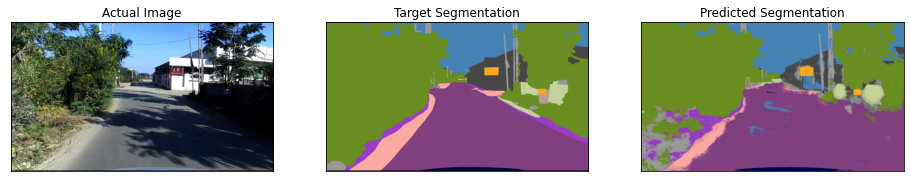

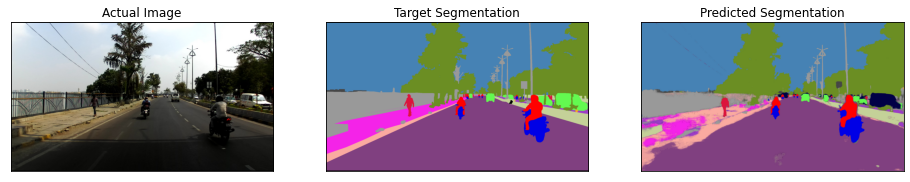

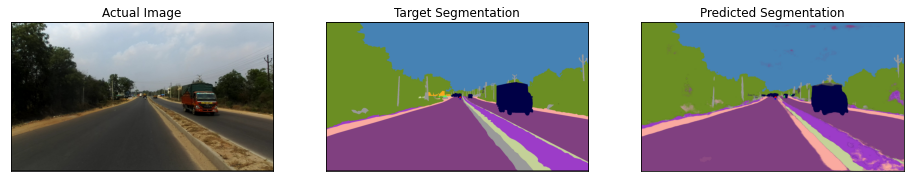

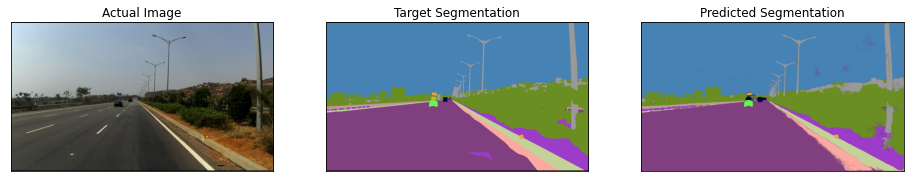

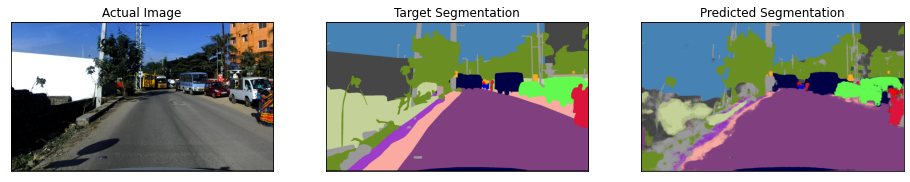

In [149]:
for i in range(5):
   prediction(test_dataloader[i][0],test_dataloader[i][1])

### Observetions:
* The segmentation output on the test data are quite decent.

### PREDICTING SEGMENTATION OF THE INDIAN TRAFFIC VIDEO

In [107]:
'''THIS CELL READS THE VIDEO FILE SAVES EACH FRAME'''

vid = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/ass-26/traffic.mp4")
count = 1
success= 1
while success:
    success, image = vid.read()
    if success == True:
        cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/ass-26/video/input/{count}.jpg",image)
    count +=1

In [108]:
'''FORMING THE DATAFRAME FOR PATHS OF EACH FRAME IN THE VIDEO'''

df_video = pd.DataFrame(glob.glob('/content/drive/MyDrive/Colab Notebooks/ass-26/video/input/*.jpg'),columns=["images"])
df_video

,images
0,/content/drive/MyDrive/Colab Notebooks/ass-26/...
1,/content/drive/MyDrive/Colab Notebooks/ass-26/...
2,/content/drive/MyDrive/Colab Notebooks/ass-26/...
3,/content/drive/MyDrive/Colab Notebooks/ass-26/...
4,/content/drive/MyDrive/Colab Notebooks/ass-26/...
...,...
3591,/content/drive/MyDrive/Colab Notebooks/ass-26/...
3592,/content/drive/MyDrive/Colab Notebooks/ass-26/...
3593,/content/drive/MyDrive/Colab Notebooks/ass-26/...
3594,/content/drive/MyDrive/Colab Notebooks/ass-26/...


In [115]:
'''THIS CELL READS FRAMES OF INPUT AND RETURNS THE SEGMENTED IMAGES OF THE VIDEO'''

def predict_total(df):
    # FOR EACH ROW IN THE DATAFRAME 
    for j in tqdm(range(df.shape[0]),position=0):
        # READ THE IMAGE 
        inp = cv2.imread(df.images.values[j])
        # RESIZING THE IMAGE
        inp = cv2.resize(inp,(1920,1088))
        # PREDICTING THE OUTPUT 
        pred = model.predict(np.expand_dims(inp,0)).round(0)
        
        # CONVERTING THE 21 CHANNEL OUTPUT TO 3 CHANNELS
        pred_img = np.zeros(shape=(1088,1920,3))
        for i in range(21):
          
            x = np.zeros((1088,1920,3))
            x[:,:,0] = pred[0,:,:,i]*label_clr2[unique_classes[i]][0]
            x[:,:,1] = pred[0,:,:,i]* label_clr2[unique_classes[i]][1]
            x[:,:,2] = pred[0,:,:,i]*label_clr2[unique_classes[i]][2]
        
            pred_img+= x
        # SAVING THE IMAGE
        imsave(re.sub("input","output",df.images.values[j]),pred_img.astype(np.uint8))

In [116]:
predict_total(df_video)

100%|██████████| 3596/3596 [1:54:12<00:00,  1.91s/it]


In [117]:
import glob

In [120]:
'''THIS CELL READS THE PREDICTED IMAGES AND CONVERTS THEM INTO A VIDEO'''
# REF : https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
img_array = []
for filename in glob.glob('/content/drive/MyDrive/Colab Notebooks/ass-26/video/output/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    
out = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/ass-26/final_project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (1920,1088))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Video Link : https://drive.google.com/file/d/1BJiBWT4UIh0ZRxJBtF3WUFJdWT5Yf9gV/view?usp=sharing
* The segmentation output of the indian traffic video is not good. This might be because the training is not done of this tyoe of dataset 
* We are also resizing the images, therefore this might also be the reason for degradation in the video queality.